<a href="https://colab.research.google.com/github/jhordi19/Ciencia_de_datos/blob/Taller/Taller_Sem10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Entrenamiento con RN

####Aplicando SMOTE para balacear clases

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3145/3145 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.4999 - auc_12: 0.4981 - loss: 0.6954 - precision_12: 0.5007 - recall_12: 0.5107 - val_accuracy: 0.5066 - val_auc_12: 0.5064 - val_loss: 0.6930 - val_precision_12: 0.5063 - val_recall_12: 0.5305
Epoch 2/10
3145/3145 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.5051 - auc_12: 0.5064 - loss: 0.6931 - precision_12: 0.5069 - recall_12: 0.4732 - val_accuracy: 0.5065 - val_auc_12: 0.5123 - val_loss: 0.6929 - val_precision_12: 0.5133 - val_recall_12: 0.2517
Epoch 3/10
3145/3145 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.5068 - auc_12: 0.5085 - loss: 0.6930 - precision_12: 0.5107 - recall_12: 0.4119 - val_accuracy: 0.5076 - val_auc_12: 0.5133 - val_loss: 0.6929 - val_precision_12: 0.5324 - val_recall_12: 0.1242
Epoch 4/10
3145/3145 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.5145 - auc_12: 0.5168 - loss: 0.6926 - precision_12: 0.5186 - recall_12: 0.3386 - val_accuracy: 0.5133 - val_auc_12: 0.5171 - val_loss: 0.6925 - val_prec

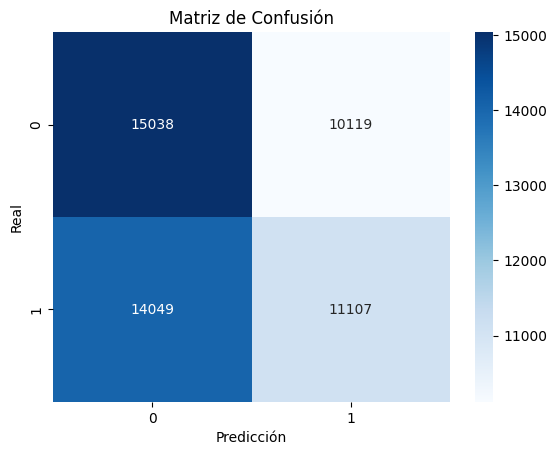

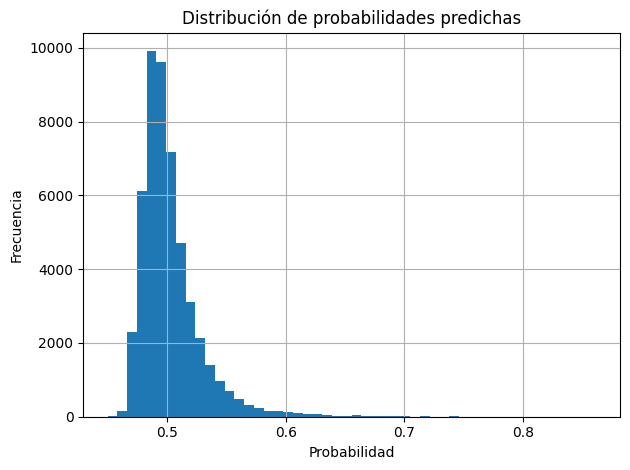

In [ ]:
# === Librerías necesarias ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns

# === Cargar dataset ===
df = pd.read_csv("hypertension_dataset.csv")
df['Hypertension'] = df['Hypertension'].map({'High': 1, 'Low': 0})
df['Family_History'] = df['Family_History'].map({'No': 0, 'Yes': 1})

# === Discretización personalizada ===
def bin_alcohol(x):
    if x == 0: return 'None'
    elif x <= 10: return 'Low'
    elif x <= 20: return 'Moderate'
    else: return 'High'

def bin_salt(x):
    if x < 5: return 'Low'
    elif x <= 10: return 'Moderate'
    else: return 'High'

df['Alcohol_Level'] = df['Alcohol_Intake'].apply(bin_alcohol)
df['Salt_Level'] = df['Salt_Intake'].apply(bin_salt)

# === Definir X e y ===
X = df.drop(['Hypertension', 'Alcohol_Intake', 'Salt_Intake'], axis=1)
y = df['Hypertension']

# === Columnas por tipo ===
numeric_cols = ['Age', 'BMI', 'Sleep_Duration']
ordinal_cols = ['Smoking_Status', 'Physical_Activity_Level', 'Stress_Level', 'Alcohol_Level', 'Salt_Level']
ordinal_map = [
    ['Never', 'Former', 'Current'],
    ['Low', 'Moderate', 'High'],
    list(range(1, 11)),
    ['None', 'Low', 'Moderate', 'High'],
    ['Low', 'Moderate', 'High']
]
binary_cols = ['Family_History']
nominal_cols = ['Gender']

# === Preprocesamiento ===
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('ord', OrdinalEncoder(categories=ordinal_map), ordinal_cols),
    ('bin', 'passthrough', binary_cols),
    ('nom', OrdinalEncoder(), nominal_cols)
])

X_preprocessed = preprocessor.fit_transform(X)

# === Aplicar SMOTE ===
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

# === División ===
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# === Modelo de red neuronal ===
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# === Entrenamiento ===
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# === Evaluación ===
y_probs = model.predict(X_test).flatten()
y_pred = (y_probs > 0.5).astype(int)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_probs):.4f}")

# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# === Distribución de probabilidades ===
plt.hist(y_probs, bins=50)
plt.title("Distribución de probabilidades predichas")
plt.xlabel("Probabilidad")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()


####Aplicando SMOTEENN

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1418/1418 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.6108 - auc_13: 0.5020 - loss: 0.6721 - precision_13: 0.3988 - recall_13: 0.0156 - val_accuracy: 0.6143 - val_auc_13: 0.5135 - val_loss: 0.6676 - val_precision_13: 0.5833 - val_recall_13: 7.9973e-04
Epoch 2/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6186 - auc_13: 0.5124 - loss: 0.6649 - precision_13: 0.6129 - recall_13: 0.0028 - val_accuracy: 0.6141 - val_auc_13: 0.5243 - val_loss: 0.6663 - val_precision_13: 0.4861 - val_recall_13: 0.0040
Epoch 3/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.6142 - auc_13: 0.5238 - loss: 0.6660 - precision_13: 0.5191 - recall_13: 0.0091 - val_accuracy: 0.6145 - val_auc_13: 0.5268 - val_loss: 0.6652 - val_precision_13: 0.5333 - val_recall_13: 0.0064
Epoch 4/10
1418/1418 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.6153 - auc_13: 0.5307 - loss: 0.6649 - precision_13: 0.5784 - recall_13: 0.0172 - val_accuracy: 0.6148 - val_auc_13: 0.5417 - val_loss: 0.6642 - val_pr

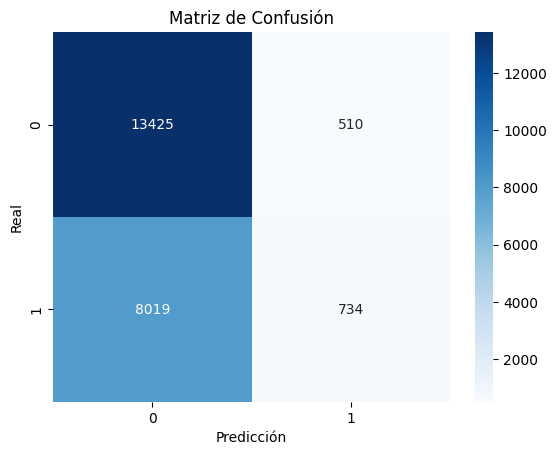

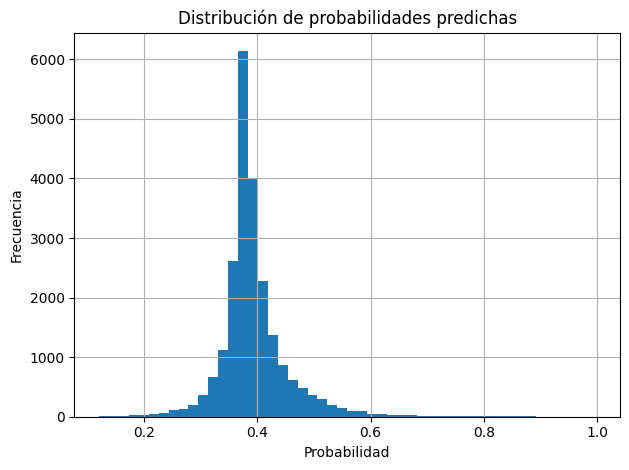

In [ ]:
# === Librerías necesarias ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.combine import SMOTEENN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns

# === Cargar dataset ===
df = pd.read_csv("hypertension_dataset.csv")
df['Hypertension'] = df['Hypertension'].map({'High': 1, 'Low': 0})
df['Family_History'] = df['Family_History'].map({'No': 0, 'Yes': 1})

# === Discretización personalizada ===
def bin_alcohol(x):
    if x == 0: return 'None'
    elif x <= 10: return 'Low'
    elif x <= 20: return 'Moderate'
    else: return 'High'

def bin_salt(x):
    if x < 5: return 'Low'
    elif x <= 10: return 'Moderate'
    else: return 'High'

df['Alcohol_Level'] = df['Alcohol_Intake'].apply(bin_alcohol)
df['Salt_Level'] = df['Salt_Intake'].apply(bin_salt)

# === Definir X e y ===
X = df.drop(['Hypertension', 'Alcohol_Intake', 'Salt_Intake'], axis=1)
y = df['Hypertension']

# === Columnas por tipo ===
numeric_cols = ['Age', 'BMI', 'Sleep_Duration']
ordinal_cols = ['Smoking_Status', 'Physical_Activity_Level', 'Stress_Level', 'Alcohol_Level', 'Salt_Level']
ordinal_map = [
    ['Never', 'Former', 'Current'],
    ['Low', 'Moderate', 'High'],
    list(range(1, 11)),
    ['None', 'Low', 'Moderate', 'High'],
    ['Low', 'Moderate', 'High']
]
binary_cols = ['Family_History']
nominal_cols = ['Gender']

# === Preprocesamiento ===
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('ord', OrdinalEncoder(categories=ordinal_map), ordinal_cols),
    ('bin', 'passthrough', binary_cols),
    ('nom', OrdinalEncoder(), nominal_cols)
])

X_preprocessed = preprocessor.fit_transform(X)

# === Aplicar SMOTEENN ===
smoteenn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smoteenn.fit_resample(X_preprocessed, y)

# === División ===
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# === Modelo de red neuronal ===
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# === Entrenamiento ===
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

# === Evaluación ===
y_probs = model.predict(X_test).flatten()
y_pred = (y_probs > 0.5).astype(int)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_probs):.4f}")

# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

# === Distribución de probabilidades ===
plt.hist(y_probs, bins=50)
plt.title("Distribución de probabilidades predichas")
plt.xlabel("Probabilidad")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()


####Se añadio ReduceLROnPlateau como callback para afinar el aprendizaje

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3145/3145 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.5016 - auc_14: 0.4999 - loss: 0.6953 - precision_14: 0.5027 - recall_14: 0.4918 - val_accuracy: 0.5017 - val_auc_14: 0.5012 - val_loss: 0.6932 - val_precision_14: 0.5052 - val_recall_14: 0.1650 - learning_rate: 0.0010
Epoch 2/30
3145/3145 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - accuracy: 0.5041 - auc_14: 0.5055 - loss: 0.6931 - precision_14: 0.5063 - recall_14: 0.4396 - val_accuracy: 0.5054 - val_auc_14: 0.5081 - val_loss: 0.6932 - val_precision_14: 0.5297 - val_recall_14: 0.0960 - learning_rate: 0.0010
Epoch 3/30
3145/3145 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.5073 - auc_14: 0.5101 - loss: 0.6929 - precision_14: 0.5086 - recall_14: 0.3380 - val_accuracy: 0.5081 - val_auc_14: 0.5149 - val_loss: 0.6927 - val_precision_14: 0.5177 - val_recall_14: 0.2353 - learning_rate: 0.0010
Epoch 4/30
3145/3145 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.5098 - auc_14: 0.5147 - loss: 0.6927 - precision_14: 0.5141 - recall_14: 0.4241 

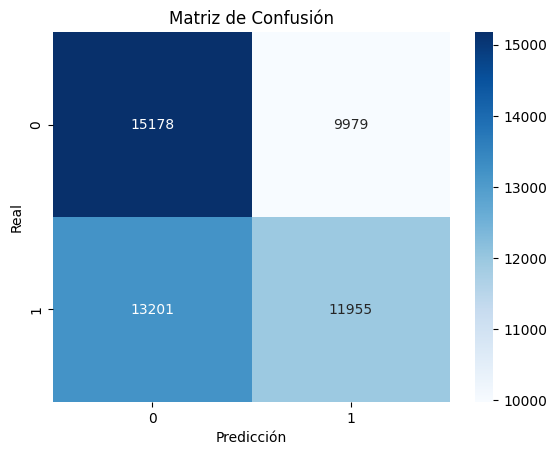

In [ ]:
# === Librerías necesarias ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns

# === Cargar dataset ===
df = pd.read_csv("hypertension_dataset.csv")
df['Hypertension'] = df['Hypertension'].map({'High': 1, 'Low': 0})
df['Family_History'] = df['Family_History'].map({'No': 0, 'Yes': 1})

# === Discretización personalizada ===
def bin_alcohol(x):
    if x == 0: return 'None'
    elif x <= 10: return 'Low'
    elif x <= 20: return 'Moderate'
    else: return 'High'

def bin_salt(x):
    if x < 5: return 'Low'
    elif x <= 10: return 'Moderate'
    else: return 'High'

df['Alcohol_Level'] = df['Alcohol_Intake'].apply(bin_alcohol)
df['Salt_Level'] = df['Salt_Intake'].apply(bin_salt)

# === Definir X e y ===
X = df.drop(['Hypertension', 'Alcohol_Intake', 'Salt_Intake'], axis=1)
y = df['Hypertension']

# === Columnas por tipo ===
numeric_cols = ['Age', 'BMI', 'Sleep_Duration']
ordinal_cols = ['Smoking_Status', 'Physical_Activity_Level', 'Stress_Level', 'Alcohol_Level', 'Salt_Level']
ordinal_map = [
    ['Never', 'Former', 'Current'],
    ['Low', 'Moderate', 'High'],
    list(range(1, 11)),
    ['None', 'Low', 'Moderate', 'High'],
    ['Low', 'Moderate', 'High']
]
binary_cols = ['Family_History']
nominal_cols = ['Gender']

# === Preprocesamiento ===
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('ord', OrdinalEncoder(categories=ordinal_map), ordinal_cols),
    ('bin', 'passthrough', binary_cols),
    ('nom', OrdinalEncoder(), nominal_cols)
])

X_preprocessed = preprocessor.fit_transform(X)

# === Aplicar SMOTE ===
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

# === División ===
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# === Modelo de red neuronal ===
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# === Callbacks ===
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# === Entrenamiento ===
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# === Evaluación ===
y_probs = model.predict(X_test).flatten()
y_pred = (y_probs > 0.5).astype(int)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_probs):.4f}")

# === Matriz de confusión ===
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

####Aplicando capas LeakyReLU

In [ ]:
# === Librerías necesarias ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import seaborn as sns

# === Cargar dataset ===
df = pd.read_csv("hypertension_dataset.csv")
df['Hypertension'] = df['Hypertension'].map({'High': 1, 'Low': 0})
df['Family_History'] = df['Family_History'].map({'No': 0, 'Yes': 1})

# === Discretización personalizada ===
def bin_alcohol(x):
    if x == 0: return 'None'
    elif x <= 10: return 'Low'
    elif x <= 20: return 'Moderate'
    else: return 'High'

def bin_salt(x):
    if x < 5: return 'Low'
    elif x <= 10: return 'Moderate'
    else: return 'High'

df['Alcohol_Level'] = df['Alcohol_Intake'].apply(bin_alcohol)
df['Salt_Level'] = df['Salt_Intake'].apply(bin_salt)

# === Definir X e y ===
X = df.drop(['Hypertension', 'Alcohol_Intake', 'Salt_Intake'], axis=1)
y = df['Hypertension']

# === Columnas por tipo ===
numeric_cols = ['Age', 'BMI', 'Sleep_Duration']
ordinal_cols = ['Smoking_Status', 'Physical_Activity_Level', 'Stress_Level', 'Alcohol_Level', 'Salt_Level']
ordinal_map = [
    ['Never', 'Former', 'Current'],
    ['Low', 'Moderate', 'High'],
    list(range(1, 11)),
    ['None', 'Low', 'Moderate', 'High'],
    ['Low', 'Moderate', 'High']
]
binary_cols = ['Family_History']
nominal_cols = ['Gender']

# === Preprocesamiento ===
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('ord', OrdinalEncoder(categories=ordinal_map), ordinal_cols),
    ('bin', 'passthrough', binary_cols),
    ('nom', OrdinalEncoder(), nominal_cols)
])

X_preprocessed = preprocessor.fit_transform(X)

# === Aplicar SMOTE ===
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

# === División ===
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

# === Modelo con LeakyReLU ===
model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),

    Dense(128),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),

    Dense(64),
    LeakyReLU(alpha=0.01),

    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)

# === Entrenamiento ===
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
    ],
    verbose=1
)

# === Evaluación ===
y_probs = model.predict(X_test).flatten()
y_pred = (y_probs > 0.5).astype(int)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_probs):.4f}")

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3145/3145 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - accuracy: 0.5026 - auc_15: 0.5024 - loss: 0.6949 - precision_15: 0.5017 - recall_15: 0.4930 - val_accuracy: 0.5060 - val_auc_15: 0.5078 - val_loss: 0.6930 - val_precision_15: 0.5129 - val_recall_15: 0.2386 - learning_rate: 0.0010
Epoch 2/30
3145/3145 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.5047 - auc_15: 0.5057 - loss: 0.6931 - precision_15: 0.5065 - recall_15: 0.4223 - val_accuracy: 0.5063 - val_auc_15: 0.5083 - val_loss: 0.6930 - val_precision_15: 0.5087 - val_recall_15: 0.3658 - learning_rate: 0.0010
Epoch 3/30
3145/3145 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - accuracy: 0.5057 - auc_15: 0.5083 - loss: 0.6930 - precision_15: 0.5060 - recall_15: 0.3206 - val_accuracy: 0.5096 - val_auc_15: 0.5148 - val_loss: 0.6928 - val_precision_15: 0.5314 - val_recall_15: 0.1626 - learning_rate: 0.0010
Epoch 4/30
3145/3145 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.5095 - auc_15: 0.5114 - loss: 0.6928 - precision_15: 0.5114 - recall_15: 0.3242 -

###Se aplicaron los siguientes cambios
learning_rate = 0.0005, EarlyStopping , Arquitectura 256–128–64 con Dropout

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


3145/3145 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - accuracy: 0.4998 - auc: 0.4996 - loss: 0.6954 - precision: 0.4991 - recall: 0.5129 - val_accuracy: 0.5036 - val_auc: 0.5063 - val_loss: 0.6930 - val_precision: 0.5045 - val_recall: 0.4108 - learning_rate: 5.0000e-04
Epoch 2/10
3145/3145 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.5054 - auc: 0.5076 - loss: 0.6932 - precision: 0.5052 - recall: 0.4421 - val_accuracy: 0.5040 - val_auc: 0.5115 - val_loss: 0.6933 - val_precision: 0.5466 - val_recall: 0.0473 - learning_rate: 5.0000e-04
Epoch 3/10
3134/3145 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5104 - auc: 0.5137 - loss: 0.6929 - precision: 0.5133 - recall: 0.4482
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
3145/3145 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.5104 - auc: 0.5137 - loss: 0.6929 - precision: 0.5133 - recall: 0.4482 - val_accuracy: 0.5084 - val_auc: 0.5093 - val_loss: 0.6932 - val_precision: 0.5279 - val_recall: 0.1589 - learning_rate:

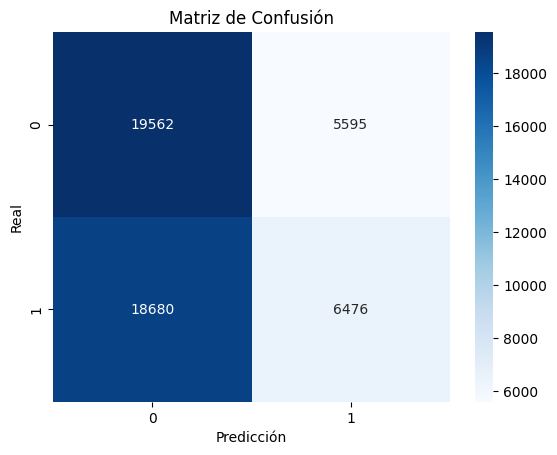

In [ ]:
# === Modelo con LeakyReLU y ajustes de hiperparámetros ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# === Cargar dataset ===
df = pd.read_csv("hypertension_dataset.csv")
df['Hypertension'] = df['Hypertension'].map({'High': 1, 'Low': 0})
df['Family_History'] = df['Family_History'].map({'No': 0, 'Yes': 1})

# === Discretización personalizada ===
def bin_alcohol(x):
    if x == 0: return 'None'
    elif x <= 10: return 'Low'
    elif x <= 20: return 'Moderate'
    else: return 'High'

def bin_salt(x):
    if x < 5: return 'Low'
    elif x <= 10: return 'Moderate'
    else: return 'High'

df['Alcohol_Level'] = df['Alcohol_Intake'].apply(bin_alcohol)
df['Salt_Level'] = df['Salt_Intake'].apply(bin_salt)

# === Definir X e y ===
X = df.drop(['Hypertension', 'Alcohol_Intake', 'Salt_Intake'], axis=1)
y = df['Hypertension']

# === Columnas por tipo ===
numeric_cols = ['Age', 'BMI', 'Sleep_Duration']
ordinal_cols = ['Smoking_Status', 'Physical_Activity_Level', 'Stress_Level', 'Alcohol_Level', 'Salt_Level']
ordinal_map = [
    ['Never', 'Former', 'Current'],
    ['Low', 'Moderate', 'High'],
    list(range(1, 10)),
    ['None', 'Low', 'Moderate', 'High'],
    ['Low', 'Moderate', 'High']
]
binary_cols = ['Family_History']
nominal_cols = ['Gender']

# === Preprocesamiento ===
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('ord', OrdinalEncoder(categories=ordinal_map), ordinal_cols),
    ('bin', 'passthrough', binary_cols),
    ('nom', OrdinalEncoder(), nominal_cols)
])

X_preprocessed = preprocessor.fit_transform(X)

# === Aplicar SMOTE ===
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

# === División ===
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.01),
    Dropout(0.3),

    Dense(128),
    LeakyReLU(alpha=0.01),
    Dropout(0.2),

    Dense(64),
    LeakyReLU(alpha=0.01),

    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc")
    ]
)

# === Callbacks ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# === Entrenamiento ===
model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# === Evaluación ===
y_probs = model.predict(X_test).flatten()
y_pred = (y_probs > 0.5).astype(int)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_probs):.4f}")

# === Matriz de Confusión ===
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matriz de Confusión")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


   Threshold  Precision    Recall        F1
6       0.40   0.500139  0.999523  0.666684
0       0.10   0.499990  1.000000  0.666658
2       0.20   0.499990  1.000000  0.666658
1       0.15   0.499990  1.000000  0.666658
3       0.25   0.499990  1.000000  0.666658


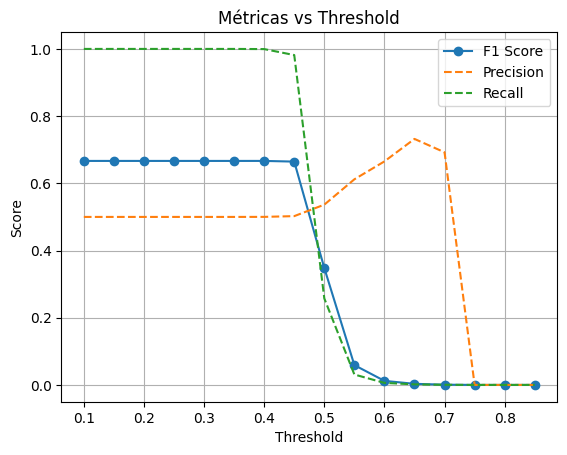

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Calcular métricas para varios thresholds
thresholds = np.arange(0.1, 0.9, 0.05)
metrics = []

for t in thresholds:
    y_pred_thresh = (y_probs > t).astype(int)
    precision = precision_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    metrics.append((t, precision, recall, f1))

# Convertir a DataFrame
df_metrics = pd.DataFrame(metrics, columns=['Threshold', 'Precision', 'Recall', 'F1'])

# Mostrar mejores valores
print(df_metrics.sort_values('F1', ascending=False).head())

# Graficar F1 vs Threshold
plt.plot(df_metrics['Threshold'], df_metrics['F1'], marker='o', label='F1 Score')
plt.plot(df_metrics['Threshold'], df_metrics['Precision'], '--', label='Precision')
plt.plot(df_metrics['Threshold'], df_metrics['Recall'], '--', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Métricas vs Threshold')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
mejor_umbral = 0.47
y_pred_final = (y_probs > mejor_umbral).astype(int)
print(classification_report(y_test, y_pred_final))
print(f"AUC: {roc_auc_score(y_test, y_probs):.4f}")


              precision    recall  f1-score   support

           0       0.54      0.10      0.17     25157
           1       0.50      0.91      0.65     25156

    accuracy                           0.51     50313
   macro avg       0.52      0.51      0.41     50313
weighted avg       0.52      0.51      0.41     50313

AUC: 0.5291


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline

# === Cargar y preparar datos ===
df = pd.read_csv("hypertension_dataset.csv")
df['Hypertension'] = df['Hypertension'].map({'High': 1, 'Low': 0})
df['Family_History'] = df['Family_History'].map({'No': 0, 'Yes': 1})

def bin_alcohol(x):
    if x == 0: return 'None'
    elif x <= 10: return 'Low'
    elif x <= 20: return 'Moderate'
    else: return 'High'

def bin_salt(x):
    if x < 5: return 'Low'
    elif x <= 10: return 'Moderate'
    else: return 'High'

df['Alcohol_Level'] = df['Alcohol_Intake'].apply(bin_alcohol)
df['Salt_Level'] = df['Salt_Intake'].apply(bin_salt)

X = df.drop(['Hypertension', 'Alcohol_Intake', 'Salt_Intake'], axis=1)
y = df['Hypertension']

# === Columnas por tipo ===
numeric_cols = ['Age', 'BMI', 'Sleep_Duration']
ordinal_cols = ['Smoking_Status', 'Physical_Activity_Level', 'Stress_Level', 'Alcohol_Level', 'Salt_Level']
ordinal_map = [
    ['Never', 'Former', 'Current'],
    ['Low', 'Moderate', 'High'],
    list(range(1, 10)),
    ['None', 'Low', 'Moderate', 'High'],
    ['Low', 'Moderate', 'High']
]
binary_cols = ['Family_History']
nominal_cols = ['Gender']

# === Preprocesador ===
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('ord', OrdinalEncoder(categories=ordinal_map), ordinal_cols),
    ('bin', 'passthrough', binary_cols),
    ('nom', OrdinalEncoder(), nominal_cols)
])

# === Pipeline: preprocesamiento + SMOTEENN + MLP ===
pipe = ImbPipeline([
    ('pre', preprocessor),
    ('smoteenn', SMOTEENN(random_state=42)),
    ('clf', MLPClassifier(
        hidden_layer_sizes=(128, 64),
        activation='relu',
        solver='adam',
        alpha=0.0005,
        learning_rate_init=0.001,
        max_iter=300,
        early_stopping=True,
        random_state=42
    ))
])

# === División y entrenamiento ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
pipe.fit(X_train, y_train)

# === Evaluación ===
y_probs = pipe.predict_proba(X_test)[:, 1]
y_pred = pipe.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_probs):.4f}")


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.28      0.69      0.40      9840
           1       0.72      0.31      0.44     25157

    accuracy                           0.42     34997
   macro avg       0.50      0.50      0.42     34997
weighted avg       0.60      0.42      0.43     34997

AUC: 0.4995


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

# =============================
# 1. Cargar y preparar datos
# =============================

df = pd.read_csv("hypertension_dataset.csv")

# Mapear variables binarias
df['Hypertension'] = df['Hypertension'].map({'High': 1, 'Low': 0})
df['Family_History'] = df['Family_History'].map({'No': 0, 'Yes': 1})

# Discretización personalizada
def bin_alcohol(x):
    if x == 0: return 'None'
    elif x <= 10: return 'Low'
    elif x <= 20: return 'Moderate'
    else: return 'High'

def bin_salt(x):
    if x < 5: return 'Low'
    elif x <= 10: return 'Moderate'
    else: return 'High'

df['Alcohol_Level'] = df['Alcohol_Intake'].apply(bin_alcohol)
df['Salt_Level'] = df['Salt_Intake'].apply(bin_salt)

# Definir X e y
X = df.drop(['Hypertension', 'Alcohol_Intake', 'Salt_Intake'], axis=1)
y = df['Hypertension']

# =============================
# 2. Definir columnas por tipo
# =============================

numeric_cols = ['Age', 'BMI', 'Sleep_Duration']
ordinal_cols = ['Smoking_Status', 'Physical_Activity_Level', 'Stress_Level', 'Alcohol_Level', 'Salt_Level']
ordinal_map = [
    ['Never', 'Former', 'Current'],
    ['Low', 'Moderate', 'High'],
    list(range(1, 10)),
    ['None', 'Low', 'Moderate', 'High'],
    ['Low', 'Moderate', 'High']
]
binary_cols = ['Family_History']
nominal_cols = ['Gender']

# =============================
# 3. Preprocesador completo
# =============================

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('ord', OrdinalEncoder(categories=ordinal_map), ordinal_cols),
    ('bin', 'passthrough', binary_cols),
    ('nom', OrdinalEncoder(), nominal_cols)
])

# =============================
# 4. Pipeline con SMOTE + MLPClassifier
# =============================

pipe = ImbPipeline([
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', MLPClassifier(
        hidden_layer_sizes=(256, 128, 64),
        activation='relu',
        solver='adam',
        alpha=0.0001,
        learning_rate_init=0.0005,
        max_iter=500,
        early_stopping=True,
        random_state=42
    ))
])

# =============================
# 5. Dividir y entrenar
# =============================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

pipe.fit(X_train, y_train)

# =============================
# 6. Evaluación
# =============================

y_probs = pipe.predict_proba(X_test)[:, 1]
y_pred = pipe.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print(f"AUC: {roc_auc_score(y_test, y_probs):.4f}")

# =============================
# 7. Exportar modelo completo
# =============================

joblib.dump(pipe, "Modelo_MLP.pkl", compress=9)
print("✅ Modelo MLP exportado como pipeline listo para integración.")



=== Classification Report ===
              precision    recall  f1-score   support

           0       0.28      0.37      0.32      9840
           1       0.72      0.63      0.67     25157

    accuracy                           0.56     34997
   macro avg       0.50      0.50      0.50     34997
weighted avg       0.60      0.56      0.57     34997

AUC: 0.5043
✅ Modelo MLP exportado como pipeline listo para integración.


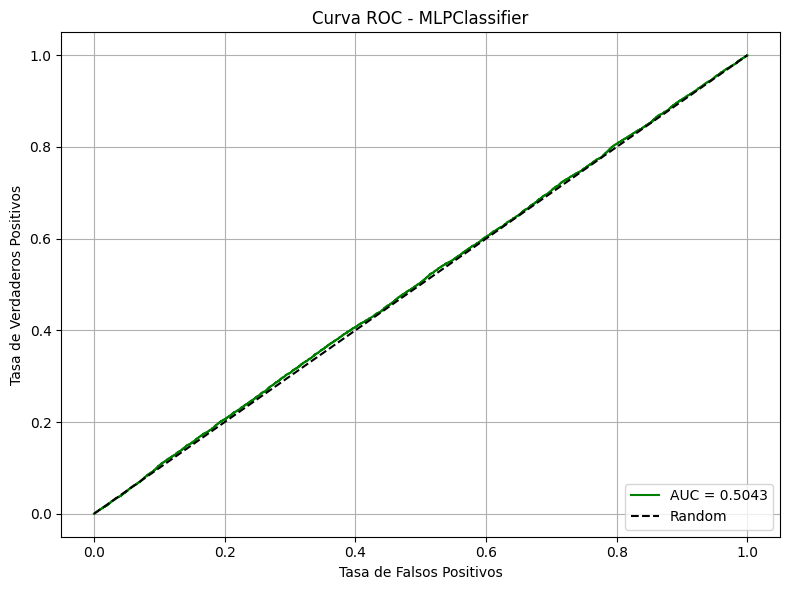

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_probs):.4f}", color='green')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC - MLPClassifier")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
